
# Bifacial Modeling - procedural

Example of bifacial modeling using pvfactors and procedural method


This example shows how to complete a bifacial modeling example using the
:py:func:`pvlib.pvsystem.pvwatts_dc` with the
:py:func:`pvlib.bifacial.pvfactors.pvfactors_timeseries` function to
transpose GHI data to both front and rear Plane of Array (POA) irradiance.

.. attention::
   To run this example, the ``solarfactors`` package (an implementation
   of the pvfactors model) must be installed.  It can be installed with
   either ``pip install solarfactors`` or ``pip install pvlib[optional]``,
   which installs all of pvlib's optional dependencies.



/tmp/ipykernel_1445839/907685730.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/tmp/ipykernel_1445839/907685730.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  times = pd.date_range('2021-06-21', '2021-06-22', freq='1T', tz=tz)


<Axes: title={'center': 'Bifacial Simulation on June Solstice'}, ylabel='DC Power'>

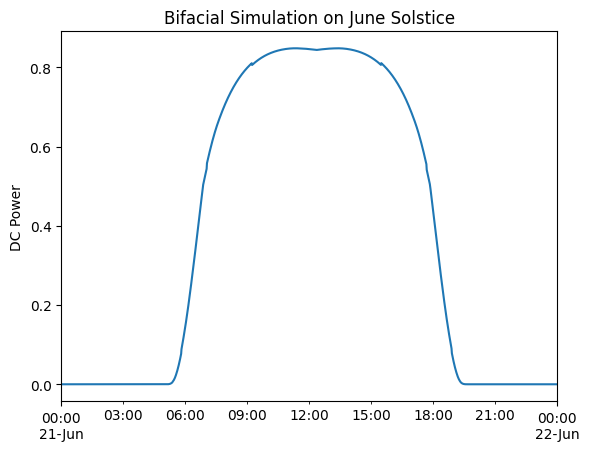

In [1]:
import pandas as pd
from pvlib import location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib import pvsystem
import matplotlib.pyplot as plt
import warnings

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

# using Greensboro, NC for this example
lat, lon = 36.084, -79.817
tz = 'Etc/GMT+5'
times = pd.date_range('2021-06-21', '2021-06-22', freq='1T', tz=tz)

# create location object and get clearsky data
site_location = location.Location(lat, lon, tz=tz, name='Greensboro, NC')
cs = site_location.get_clearsky(times)

# get solar position data
solar_position = site_location.get_solarposition(times)

# set ground coverage ratio and max_angle to
# pull orientation data for a single-axis tracker
gcr = 0.35
max_phi = 60
orientation = tracking.singleaxis(solar_position['apparent_zenith'],
                                  solar_position['azimuth'],
                                  max_angle=max_phi,
                                  backtrack=True,
                                  gcr=gcr
                                  )

# set axis_azimuth, albedo, pvrow width and height, and use
# the pvfactors engine for both front and rear-side absorbed irradiance
axis_azimuth = 180
pvrow_height = 3
pvrow_width = 4
albedo = 0.2

# explicity simulate on pvarray with 3 rows, with sensor placed in middle row
# users may select different values depending on needs
irrad = pvfactors_timeseries(solar_position['azimuth'],
                             solar_position['apparent_zenith'],
                             orientation['surface_azimuth'],
                             orientation['surface_tilt'],
                             axis_azimuth,
                             cs.index,
                             cs['dni'],
                             cs['dhi'],
                             gcr,
                             pvrow_height,
                             pvrow_width,
                             albedo,
                             n_pvrows=3,
                             index_observed_pvrow=1
                             )

# turn into pandas DataFrame
irrad = pd.concat(irrad, axis=1)

# using bifaciality factor and pvfactors results, create effective irradiance
bifaciality = 0.75
effective_irrad_bifi = irrad['total_abs_front'] + (irrad['total_abs_back']
                                                   * bifaciality)

# get cell temperature using the Faiman model
temp_cell = temperature.faiman(effective_irrad_bifi, temp_air=25,
                               wind_speed=1)

# using the pvwatts_dc model and parameters detailed above,
# set pdc0 and return DC power for both bifacial and monofacial
pdc0 = 1
gamma_pdc = -0.0043
pdc_bifi = pvsystem.pvwatts_dc(effective_irrad_bifi,
                               temp_cell,
                               pdc0,
                               gamma_pdc=gamma_pdc
                               ).fillna(0)
pdc_bifi.plot(title='Bifacial Simulation on June Solstice', ylabel='DC Power')

For illustration, perform monofacial simulation using pvfactors front-side
irradiance (AOI-corrected), and plot along with bifacial results.



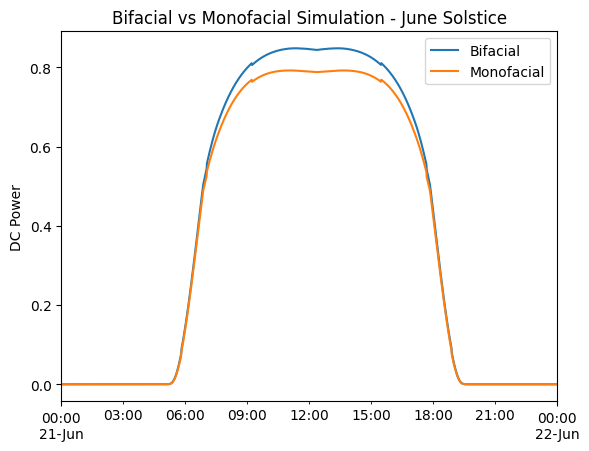

In [2]:
effective_irrad_mono = irrad['total_abs_front']
pdc_mono = pvsystem.pvwatts_dc(effective_irrad_mono,
                               temp_cell,
                               pdc0,
                               gamma_pdc=gamma_pdc
                               ).fillna(0)

# plot monofacial results
plt.figure()
plt.title('Bifacial vs Monofacial Simulation - June Solstice')
pdc_bifi.plot(label='Bifacial')
pdc_mono.plot(label='Monofacial')
plt.ylabel('DC Power')
plt.legend()
# sphinx_gallery_thumbnail_number = 2